# Optimizing Random Forest (Model Selection - 1)

- Read the Best Selected Feature Set
- Optimize the Random Forest with the best Feature Set

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
import joblib

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
from datetime import datetime, date
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
import joblib

In [3]:
start_time = datetime.now()
print ('Current Starting Time is : ',start_time)

Current Starting Time is :  2021-09-04 17:46:39.475407


In [4]:
# function to save classification report
def classification_report_csv(report,classifier_name,ascore):
    report_data = []
    counter=0
    lines = report.split('\n')
    
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        
        
        row['classifier'] = classifier_name
        row['accuracy_score'] = ascore
        
        if counter==0:
            row['class'] = row_data[2].strip()
            row['precision'] = float(row_data[3].strip())
            row['recall'] = float(row_data[4].strip())
            row['f1_score'] = float(row_data[5].strip())
            row['accuracy_score'] = ascore
        elif counter==1:
            row['class'] = row_data[0].strip()
            row['precision'] = float(row_data[1].strip())
            row['recall'] = float(row_data[2].strip())
            row['f1_score'] = float(row_data[3].strip())
            row['accuracy_score'] = ascore
        elif counter==2:
            row['class'] = row_data[1].strip()
            row['precision'] = float(row_data[2].strip())
            row['recall'] = float(row_data[3].strip())
            row['f1_score'] = float(row_data[4].strip())
        
        report_data.append(row)
        
        counter+=1
        
    dataframe = pd.DataFrame.from_dict(report_data)
        
    if os.path.exists('classification_reports/classification_report.csv'):
        df_cr = pd.read_csv('classification_reports/classification_report.csv')
                
        t = df_cr[df_cr['classifier']==classifier_name].index
        if len(t)>0:
            df_cr.drop(t, inplace=True)
        
        df_cr = pd.concat([df_cr,dataframe])
        df_cr.to_csv('classification_reports/classification_report.csv', index = False)
    else:
        dataframe.to_csv('classification_reports/classification_report.csv', index = False)

**reading all the feature set files**

In [5]:
# base feature set with advanced and mean encoded features
df_base_adv_mean = pd.read_csv('input/feature_sets/base_adv_mean.csv')

# 1. Model with Base + Advanced + Mean Features

In [6]:
X = df_base_adv_mean.drop(['status_group','id','functional needs repair','non functional'], axis=1)
y = df_base_adv_mean['status_group'].values

# i have changed below to test size .21 based on results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21, random_state=42)

**verifying the results as were during the feature set selection**

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46926 entries, 53100 to 56422
Data columns (total 54 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   region_perf                      46926 non-null  int64  
 1   source_type_perf                 46926 non-null  int64  
 2   amount_tsh_zero                  46926 non-null  int64  
 3   gps_gt_668                       46926 non-null  int64  
 4   cons_year_zero                   46926 non-null  int64  
 5   pump_age_group                   46926 non-null  int64  
 6   all_zeros                        46926 non-null  int64  
 7   district_code                    46926 non-null  int64  
 8   basin                            46926 non-null  int64  
 9   region                           46926 non-null  int64  
 10  region_code                      46926 non-null  int64  
 11  public_meeting_label             46926 non-null  int64  
 12  scheme_managem

**fit the model**

In [8]:
# get the rf object
rf_base = RandomForestClassifier(n_estimators=101, n_jobs=-1)

# fit the same base model
rf_clf = rf_base.fit(X_train, y_train)

# prediction
rf_clf_pred = rf_base.predict(X_test)

**confusion matrix**

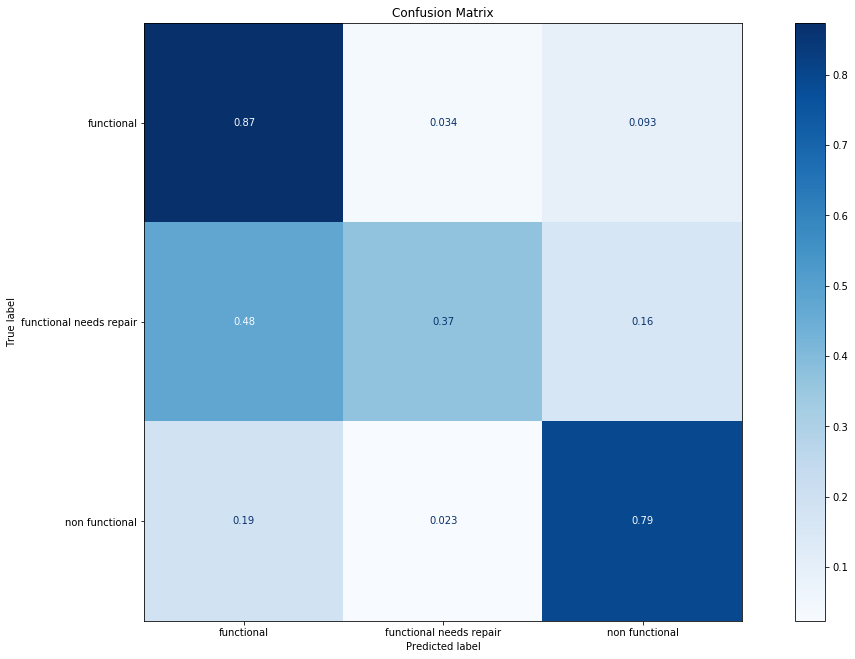

In [9]:
# Generate confusion matrix
fig, axes = plt.subplots(figsize=(19,11))

matrix = plot_confusion_matrix(rf_clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true',ax= axes)

plt.title('Confusion Matrix')
plt.show(matrix)
plt.show()

**classification report**

In [10]:
print(classification_report(y_test, rf_clf_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.87      0.85      6790
functional needs repair       0.49      0.37      0.42       885
         non functional       0.83      0.79      0.81      4799

               accuracy                           0.81     12474
              macro avg       0.71      0.68      0.69     12474
           weighted avg       0.80      0.81      0.80     12474



# Optimizing the Random Forest

### Halving Search CV-1

In [11]:
# parameter grid
pgrid = {    
    'max_depth' : [51,None],    
    'min_samples_split' : [5,6],
    'min_samples_leaf' : [1,2],    
}

# specifying the cv
cv_skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# specifying the model 
rfgs = RandomForestClassifier(n_jobs=-1, verbose=1)

# keep track of the date and time
dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")


# specify the grid search cv
cv = HalvingGridSearchCV(estimator=rfgs,param_grid=pgrid,cv=cv_skf,n_jobs=-1,verbose=10, scoring='accuracy',random_state=0)

# pring the date and time 
print("date and time =", dt_string)

date and time = 04/09/2021 17:46:44


**executing the halving grid search**

In [12]:
%%time
joblib.dump(cv.fit(X_train,y_train),'models/HalvingGridSearchCV.pkl')

fd is '7'
fd is '7'
fd is '7'
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 15642
max_resources_: 46926
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 15642
Fitting 5 folds for each of 8 candidates, totalling 40 fits
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished


Wall time: 55.6 s


['models/HalvingGridSearchCV.pkl']

**display the best params**

In [13]:
loaded_cv = joblib.load('models/HalvingGridSearchCV.pkl')
loaded_cv.best_params_

{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 6}

**get the best estimator model and execute predictions on it, along with the classification score**

In [14]:
rf_best = loaded_cv.best_estimator_

# get the prediction
rfpred = rf_best.predict(X_test)

# print classification report
cr = classification_report(y_test, rfpred)
print(cr)
classification_report_csv(cr,'HalvingGridSearchCV.pkl',accuracy_score(y_test, rfpred))


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      6790
functional needs repair       0.58      0.32      0.41       885
         non functional       0.85      0.78      0.82      4799

               accuracy                           0.82     12474
              macro avg       0.75      0.67      0.69     12474
           weighted avg       0.81      0.82      0.81     12474



### Halving Search CV - 2

In [15]:
# parameter grid
pgrid = {    
    'max_depth' : [51,None],    
    'min_samples_split' : [5,6],
    'min_samples_leaf' : [1,2],    
}

# specifying the cv
cv_skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# specifying the model 
rfgs = RandomForestClassifier(n_jobs=-1, verbose=1)

# keep track of the date and time
dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")


# specify the grid search cv
cv = HalvingGridSearchCV(
    estimator=rfgs,param_grid=pgrid,cv=cv_skf,n_jobs=-1,verbose=10,scoring='balanced_accuracy',random_state=0,
    resource='n_estimators',max_resources=1000)

# pring the date and time 
print("date and time =", dt_string)

date and time = 04/09/2021 17:47:41


**executing the halving grid search cv-2**

In [16]:
%%time
joblib.dump(cv.fit(X_train,y_train),'models/HalvingGridSearchCV_2.pkl')

fd is '7'
fd is '7'
fd is '7'
fd is '7'
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 333
max_resources_: 1000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 333
Fitting 5 folds for each of 8 candidates, totalling 40 fits
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
f

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 999 out of 999 | elapsed:   20.7s finished


Wall time: 9min 4s


['models/HalvingGridSearchCV_2.pkl']

**display the best params**

In [17]:
loaded_cv = joblib.load('models/HalvingGridSearchCV_2.pkl')
loaded_cv.best_params_

{'max_depth': 51,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 999}

**get the best estimator model and execute predictions on it, along with the classification score**

In [18]:
rf_best = loaded_cv.best_estimator_

# get the prediction
rfpred = rf_best.predict(X_test)

# print classification report
cr = classification_report(y_test, rfpred)

print(cr)
classification_report_csv(cr,'HalvingGridSearchCV_2.pkl',accuracy_score(y_test, rfpred))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 999 out of 999 | elapsed:    0.9s finished


                         precision    recall  f1-score   support

             functional       0.82      0.89      0.85      6790
functional needs repair       0.54      0.36      0.43       885
         non functional       0.84      0.79      0.82      4799

               accuracy                           0.81     12474
              macro avg       0.73      0.68      0.70     12474
           weighted avg       0.81      0.81      0.81     12474



### Halving Search CV - 3

In [19]:
# parameter grid
pgrid = {    
    'n_estimators':[451,751],
    'min_samples_split' : [5,6],
    'min_samples_leaf' : [1,2],    
}

# specifying the cv
cv_skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# specifying the model 
rfgs = RandomForestClassifier(n_jobs=-1, verbose=1)

# keep track of the date and time
dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")


# specify the grid search cv
cv = HalvingGridSearchCV(
    estimator=rfgs,param_grid=pgrid,cv=cv_skf,n_jobs=-1,verbose=10,scoring='accuracy',random_state=0,
    resource='max_depth',max_resources=150)

# pring the date and time 
print("date and time =", dt_string)

date and time = 04/09/2021 17:56:51


**executing the halving grid search cv-2**

In [20]:
%%time
joblib.dump(cv.fit(X_train,y_train),'models/HalvingGridSearchCV_3.pkl')

fd is '7'
fd is '7'
fd is '7'
fd is '7'
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 50
max_resources_: 150
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 50
Fitting 5 folds for each of 8 candidates, totalling 40 fits
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd i

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 751 out of 751 | elapsed:   14.7s finished


Wall time: 10min 21s


['models/HalvingGridSearchCV_3.pkl']

**display the best params**

In [21]:
loaded_cv = joblib.load('models/HalvingGridSearchCV_3.pkl')
loaded_cv.best_params_

{'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 751,
 'max_depth': 150}

**get the best estimator model and execute predictions on it, along with the classification score**

In [22]:
rf_best = loaded_cv.best_estimator_

# get the prediction
rfpred = rf_best.predict(X_test)

# print classification report
cr = classification_report(y_test, rfpred)

print(cr)

classification_report_csv(cr,'HalvingGridSearchCV_3.pkl',accuracy_score(y_test, rfpred))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 751 out of 751 | elapsed:    0.5s finished


                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      6790
functional needs repair       0.58      0.33      0.42       885
         non functional       0.85      0.79      0.82      4799

               accuracy                           0.82     12474
              macro avg       0.75      0.67      0.70     12474
           weighted avg       0.81      0.82      0.81     12474



### Randomized Grid Search -1

In [23]:
# parameter grid
pgrid = {    
    'max_depth' : [51,None],    
    'max_features' : ['sqrt','log2'],
    'min_samples_split' : [5,6],
    'min_samples_leaf' : [1,2,3],
    'criterion' : ['gini','entropy']    
}

# specifying the cv
cv_skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# specifying the model 
rfgs = RandomForestClassifier(n_jobs=-1, verbose=1)

# keep track of the date and time
dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")

# specify the grid search cv
cv = RandomizedSearchCV(estimator=rfgs,param_distributions=pgrid,cv=cv_skf,n_jobs=-1, 
                        verbose=10, scoring='accuracy',random_state=0)

# pring the date and time 
print("date and time =", dt_string)

date and time = 04/09/2021 18:07:17


**executing the randomized grid search cv-1**

In [24]:
%%time
joblib.dump(cv.fit(X_train,y_train),'models/RandomizedSearchCV.pkl')

fd is '7'
fd is '7'
fd is '7'
fd is '7'
Fitting 5 folds for each of 10 candidates, totalling 50 fits
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished


Wall time: 1min 19s


['models/RandomizedSearchCV.pkl']

**display the best params**

In [25]:
loaded_cv = joblib.load('models/RandomizedSearchCV.pkl')
loaded_cv.best_params_

{'min_samples_split': 5,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': None,
 'criterion': 'entropy'}

**get the best estimator model and execute predictions on it, along with the classification score**

In [26]:
rf_best = loaded_cv.best_estimator_

# get the prediction
rfpred = rf_best.predict(X_test)

# print classification report
cr = classification_report(y_test, rfpred)

print(cr)

classification_report_csv(cr,'RandomizedSearchCV.pkl',accuracy_score(y_test, rfpred))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      6790
functional needs repair       0.59      0.31      0.41       885
         non functional       0.86      0.78      0.81      4799

               accuracy                           0.82     12474
              macro avg       0.75      0.66      0.69     12474
           weighted avg       0.81      0.82      0.81     12474



### Randomized Grid Search - 2

In [27]:
# parameter grid
pgrid = {    
    'n_estimators': [451,751,1000,1100],
    'max_depth' : [51,None],    
    'min_samples_split' : [3,5],
    'min_samples_leaf' : [1,2],
    'criterion' : ['gini','entropy']  
}

# specifying the cv
cv_skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# specifying the model 
rfgs = RandomForestClassifier(n_jobs=-1, verbose=1)

# keep track of the date and time
dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")

# specify the grid search cv
cv = RandomizedSearchCV(estimator=rfgs,param_distributions=pgrid,cv=cv_skf,n_jobs=-1,verbose=10,
                        scoring='balanced_accuracy',random_state=0)

# pring the date and time 
print("date and time =", dt_string)

date and time = 04/09/2021 18:08:37


**executing the randomized grid search cv-2**

In [28]:
%%time
joblib.dump(cv.fit(X_train,y_train),'models/RandomizedSearchCV_2.pkl')

fd is '7'
fd is '7'
fd is '7'
fd is '7'
Fitting 5 folds for each of 10 candidates, totalling 50 fits
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 751 out of 751 | elapsed:   18.6s finished


Wall time: 12min 52s


['models/RandomizedSearchCV_2.pkl']

**display the best params**

In [29]:
loaded_cv = joblib.load('models/RandomizedSearchCV_2.pkl')
loaded_cv.best_params_

{'n_estimators': 751,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_depth': 51,
 'criterion': 'entropy'}

**get the best estimator model and execute predictions on it, along with the classification score**

In [30]:
rf_best = loaded_cv.best_estimator_

# get the prediction
rfpred = rf_best.predict(X_test)

# print classification report
cr = classification_report(y_test, rfpred)

print(cr)

classification_report_csv(cr,'RandomizedSearchCV_2.pkl',accuracy_score(y_test, rfpred))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 751 out of 751 | elapsed:    0.6s finished


                         precision    recall  f1-score   support

             functional       0.82      0.88      0.85      6790
functional needs repair       0.52      0.37      0.43       885
         non functional       0.84      0.79      0.81      4799

               accuracy                           0.81     12474
              macro avg       0.73      0.68      0.70     12474
           weighted avg       0.80      0.81      0.81     12474



### Grid Search - 1

In [31]:
# parameter grid
pgrid = {
    'n_estimators'      : [451,1001],
    'bootstrap'         : [True,False],
    'criterion'         : ['gini','entropy'],
    'max_depth'         : [21,51],        
    'min_samples_split' : [2,3,5],
    'min_samples_leaf'  : [1,2,3]
}

# specifying the cv
cv_ss = StratifiedShuffleSplit(n_splits=3, train_size=0.75, test_size=.25,random_state=0)

# specifying the model 
rfgs = RandomForestClassifier(n_jobs=-1, verbose=1)

# keep track of the date and time
dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")

# specify the grid search cv
cv = GridSearchCV(estimator=rfgs, param_grid=pgrid, cv=cv_ss, n_jobs=-1, verbose=10, scoring='accuracy')

# pring the date and time 
print("date and time =", dt_string)

date and time = 04/09/2021 18:21:34


**execute grid search 1**

In [32]:
%%time
joblib.dump(cv.fit(X_train,y_train),'models/GridSearchCV.pkl')

fd is '7'
fd is '7'
fd is '7'
fd is '7'
Fitting 3 folds for each of 144 candidates, totalling 432 fits
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '

fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'


fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 1001 out of 1001 | elapsed:   20.7s finished


Wall time: 1h 37min 22s


['models/GridSearchCV.pkl']

**display the best params**

In [33]:
loaded_cv = joblib.load('models/GridSearchCV.pkl')
loaded_cv.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 51,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1001}

**get the best estimator model and execute predictions on it, along with the classification score**

In [34]:
rf_best = loaded_cv.best_estimator_

# get the prediction
rfpred = rf_best.predict(X_test)

# print classification report
cr = classification_report(y_test, rfpred)

print(cr)

classification_report_csv(cr,'GridSearchCV.pkl',accuracy_score(y_test, rfpred))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1001 out of 1001 | elapsed:    0.8s finished


                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      6790
functional needs repair       0.58      0.33      0.42       885
         non functional       0.85      0.79      0.82      4799

               accuracy                           0.82     12474
              macro avg       0.75      0.67      0.70     12474
           weighted avg       0.81      0.82      0.81     12474



### Grid Search - 2

In [35]:
# parameter grid 
pgrid = {
    'n_estimators' : [451,751],
    'max_depth' : [51,None],    
    'max_features' : ['sqrt','log2','auto'],
    'min_samples_split' : [5,6],
    'min_samples_leaf' : [1,2,3],
    'bootstrap': [True, False]
}

# specifying the cv
cv_skf = StratifiedKFold(n_splits=3, random_state=None, shuffle=False) # need to change to 3 splits based on results

# specifying the model 
rfgs = RandomForestClassifier(n_jobs=-1, verbose=1)

# keep track of the date and time
dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")

# specify the grid search cv
cv = GridSearchCV(estimator=rfgs, param_grid=pgrid, cv=cv_skf, n_jobs=-1, verbose=10, scoring='balanced_accuracy')

# pring the date and time 
print("date and time =", dt_string)

date and time = 04/09/2021 19:59:02


**execuate the grid search - 2**

In [36]:
%%time
joblib.dump(cv.fit(X_train,y_train),'models/GridSearchCV_2.pkl')

fd is '7'
fd is '7'
fd is '7'
fd is '7'
Fitting 3 folds for each of 144 candidates, totalling 432 fits
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '

fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'


fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'
fd is '7'


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 751 out of 751 | elapsed:   22.2s finished


Wall time: 1h 3min 29s


['models/GridSearchCV_2.pkl']

**display the best param**

In [37]:
loaded_cv = joblib.load('models/GridSearchCV_2.pkl')
loaded_cv.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 751}

**get the best estimator model and execute predictions on it, along with the classification score**

In [38]:
rf_best = loaded_cv.best_estimator_

# get the prediction
rfpred = rf_best.predict(X_test)

# print classification report
cr = classification_report(y_test, rfpred)

print(cr)

classification_report_csv(cr,'GridSearchCV_2.pkl',accuracy_score(y_test, rfpred))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 751 out of 751 | elapsed:    0.7s finished


                         precision    recall  f1-score   support

             functional       0.82      0.88      0.85      6790
functional needs repair       0.52      0.37      0.43       885
         non functional       0.83      0.80      0.81      4799

               accuracy                           0.81     12474
              macro avg       0.72      0.68      0.70     12474
           weighted avg       0.80      0.81      0.81     12474



# Showing the Results - Sorted by Accuracy 

In [42]:
df_cr = pd.read_csv('classification_reports/classification_report.csv')
df_cr[['classifier','accuracy_score']].drop_duplicates().sort_values(by='accuracy_score', ascending=False)

,classifier,accuracy_score
6,HalvingGridSearchCV_3.pkl,0.816819
15,GridSearchCV.pkl,0.815376
0,HalvingGridSearchCV.pkl,0.815216
9,RandomizedSearchCV.pkl,0.815055
3,HalvingGridSearchCV_2.pkl,0.813773
12,RandomizedSearchCV_2.pkl,0.810566
18,GridSearchCV_2.pkl,0.809524


In [40]:
end_time = datetime.now()
print ('Current Starting Time is : ',end_time)
c = end_time - start_time  

Current Starting Time is :  2021-09-04 21:02:37.853357


In [41]:
print('The execution ended after {} minutes'.format(c.seconds/60))

The execution ended after 195.96666666666667 minutes


Halving Grid Search CV performs best, but it is important to see which classifier performs well at the class **functional needs repair**

In [46]:
df_cr[df_cr['class']=='functional needs repair']\
[['classifier','recall']].drop_duplicates().sort_values(by='recall', ascending=False).reset_index(drop=True)

,classifier,recall
0,RandomizedSearchCV_2.pkl,0.37
1,GridSearchCV_2.pkl,0.37
2,HalvingGridSearchCV_2.pkl,0.36
3,HalvingGridSearchCV_3.pkl,0.33
4,GridSearchCV.pkl,0.33
5,HalvingGridSearchCV.pkl,0.32
6,RandomizedSearchCV.pkl,0.31


In [ ]:
So RandomizedSearchCV_2.pkl performs well, GridSearchCV_2.pkl too, but it is also obvious that 0.37 isn't a good number

What we will do next is, that first we will build on the best params on all models to see if there's any differe